### Task 3 

Compare the embedded approach results with the test set

1. Random data removing - 10 points per 24h period
2. Calculate the error between the imputed data and actual data.
3. Do it 10 000 times for each file
4. Calculate summary statistics the errors for each hour for each file (https://pandas.pydata.org/pandas-docs/stable/getting_started/intro_tutorials/06_calculate_statistics.html, https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/)
5. One box plot for 24h for each sensor.

In [37]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
### Get all the paths

paths = []

for root, dirs, files in os.walk("data", topdown=False):
   for name in files:
      paths.append(os.path.join(root, name))

In [3]:
def get_clean_dataframe(path):
    data = pd.read_csv(path)
    df = pd.DataFrame(data)
    df["Time"] = pd.to_datetime(df["Time"])

    # Remove duplicates
    df = df.drop_duplicates(subset=["Time"], keep=False) 
    return df

In [68]:
def get_samples(df, random_state):
    # Extract 10 random values per 24-hour period
    df["date"] = df["Time"].dt.date
    grouped = df.groupby("date")
    sampled_data = grouped.sample(n=10, random_state=random_state)
    remaining_data = df.drop(sampled_data.index)
    return sampled_data, remaining_data

In [5]:
def get_data_with_nans(df):
    full_time_range = pd.date_range(start=df["Time"].min(), end=df["Time"].max(), freq="min")
    df = df.set_index("Time").reindex(full_time_range)
    df = df.rename_axis("Time").reset_index()
    df["time_diff"] = df["Time"].diff().dt.total_seconds()
    df["dt_sound_level_dB"] = np.where((df["time_diff"] == 60) | (df.index == 0), df["dt_sound_level_dB"], np.nan)
    df = df.drop(columns=["time_diff"])
    return df

In [6]:
def get_median_values(group):
    if not group.isna().all():
        return np.ceil(group.median())

def get_imputed_data(df):
    df["hour"] = df["Time"].dt.hour
    df["minute"] = df["Time"].dt.minute
    imputed_values = df.groupby(["hour", "minute"])["dt_sound_level_dB"].transform(get_median_values)
    if imputed_values.isna().any():
        imputed_values = imputed_values.interpolate(method="linear", limit_direction="both")
        
    df["dt_sound_level_dB"] = df["dt_sound_level_dB"].fillna(imputed_values)
    return df

In [73]:
def get_error_stats(path):
    dataframe = get_clean_dataframe(path)
    error_data = []
    
    for iteration in range(100):
        sampled_data, remaining_data = get_samples(dataframe, random_state=iteration)
        remaining_data_with_nans = get_data_with_nans(remaining_data)
        imputed_data = get_imputed_data(remaining_data_with_nans)
        imputed_subset = imputed_data.loc[sampled_data.index]

        error = pd.DataFrame()
        error['error_db_level'] = np.abs(sampled_data["dt_sound_level_dB"] - imputed_subset["dt_sound_level_dB"])
        error['hour'] = imputed_subset['hour']
        error['iteration'] = iteration
        error_data.append(error)
        
    errors = pd.concat(error_data, ignore_index=True)
    grouped_data = errors.groupby('hour')['error_db_level'].agg(list)
    return grouped_data

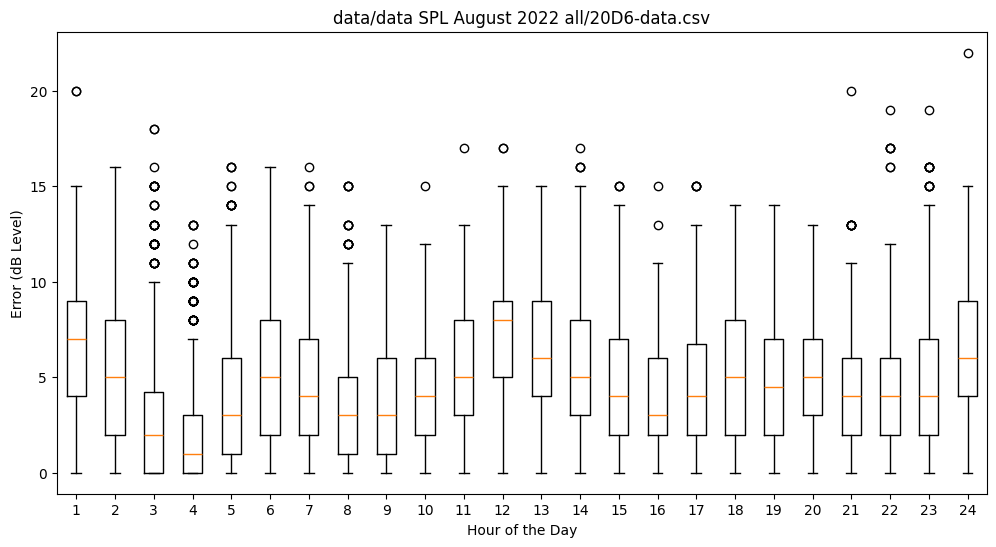

In [77]:
error_stats = get_error_stats(paths[0])

plt.figure(figsize=(12, 6))
plt.boxplot(error_stats)

plt.title(paths[0])
plt.xlabel("Hour of the Day")
plt.ylabel("Error (dB Level)")

plt.show()